# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
from dotenv import load_dotenv
import os

env_path = '../../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
today

datetime.datetime(2024, 11, 18, 20, 17, 32, 643113)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login(project='mlfs_lab1')
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163420
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry, Get Weather Forecast Features with Feature View</span>

In [4]:
mr = project.get_model_registry()

retrieved_model1 = mr.get_model(
    name="aq_xgboost_model_1",
    version=1,
)
retrieved_model2 = mr.get_model(
    name="aq_xgboost_model_2",
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=5,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir1 = retrieved_model1.download()
saved_model_dir2 = retrieved_model2.download()

display(saved_model_dir1)
display(saved_model_dir2)

Connected. Call `.close()` to terminate connection gracefully.


'C:\\Users\\silve\\AppData\\Local\\Temp\\a9fa0345-a231-454e-b09a-e30ac9dce5b2\\aq_xgboost_model_1/1'

'C:\\Users\\silve\\AppData\\Local\\Temp\\6f3bae63-9d48-4c48-958d-5b7b774486ea\\aq_xgboost_model_2/1'

In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model1 = XGBRegressor()

retrieved_xgboost_model1.load_model(saved_model_dir1 + "/model1.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model1

XGBRegressor(base_score='9.531839E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
retrieved_xgboost_model2 = XGBRegressor()

retrieved_xgboost_model2.load_model(saved_model_dir2 + "/model2.json")

retrieved_xgboost_model2

XGBRegressor(base_score='9.531839E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
batch_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by=['date'], ascending=True, ignore_index=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,pm25_21
0,2024-11-15 00:00:00+00:00,19.900000,0.0,7.993297,35.837746,shanghai,82.0,72.0,93.0,87.0,...,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0
1,2024-11-16 00:00:00+00:00,17.799999,0.0,10.182337,8.130019,shanghai,NaN,82.0,72.0,93.0,...,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0
2,2024-11-17 00:00:00+00:00,14.200000,0.0,16.279802,18.034380,shanghai,NaN,NaN,82.0,72.0,...,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0
3,2024-11-18 00:00:00+00:00,12.000000,0.0,13.779114,19.855309,shanghai,NaN,NaN,NaN,82.0,...,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0
4,2024-11-19 00:00:00+00:00,12.750000,0.0,5.506941,348.690094,shanghai,NaN,NaN,NaN,NaN,...,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0
5,2024-11-20 00:00:00+00:00,13.050000,0.0,6.915374,38.659828,shanghai,NaN,NaN,NaN,NaN,...,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0
6,2024-11-21 00:00:00+00:00,11.300000,0.0,7.091177,336.037506,shanghai,NaN,NaN,NaN,NaN,...,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0
7,2024-11-22 00:00:00+00:00,11.200000,0.0,8.049845,349.695221,shanghai,NaN,NaN,NaN,NaN,...,61.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0
8,2024-11-23 00:00:00+00:00,12.200000,0.0,5.154416,77.905258,shanghai,NaN,NaN,NaN,NaN,...,87.0,61.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_yesterday"]])

l1 = []
for i in weather_fg.features:
    if i.name != 'date' and i.name != 'city' and i.name != 'pm25_21':
        l1.append(i.name)

batch_data['predicted_pm25_1'] = None

for i in range(0, len(batch_data)):
    p = retrieved_xgboost_model1.predict(batch_data.iloc[[i]][l1])[0]
    batch_data.at[i, 'predicted_pm25_1'] = p
    index = 1
    for j in range(i+1, batch_data.shape[0]):
        batch_data.at[j, f"pm25_{index}"] = p
        index += 1

display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,pm25_21,predicted_pm25_1
0,2024-11-15 00:00:00+00:00,19.900000,0.0,7.993297,35.837746,shanghai,82.000000,72.000000,93.000000,87.000000,...,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0,104.30471
1,2024-11-16 00:00:00+00:00,17.799999,0.0,10.182337,8.130019,shanghai,104.304710,82.000000,72.000000,93.000000,...,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,98.124367
2,2024-11-17 00:00:00+00:00,14.200000,0.0,16.279802,18.034380,shanghai,98.124367,104.304710,82.000000,72.000000,...,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,62.972042
3,2024-11-18 00:00:00+00:00,12.000000,0.0,13.779114,19.855309,shanghai,62.972042,98.124367,104.304710,82.000000,...,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,73.561996
4,2024-11-19 00:00:00+00:00,12.750000,0.0,5.506941,348.690094,shanghai,73.561996,62.972042,98.124367,104.304710,...,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,83.917076
5,2024-11-20 00:00:00+00:00,13.050000,0.0,6.915374,38.659828,shanghai,83.917076,73.561996,62.972042,98.124367,...,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,112.325432
6,2024-11-21 00:00:00+00:00,11.300000,0.0,7.091177,336.037506,shanghai,112.325432,83.917076,73.561996,62.972042,...,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,139.821976
7,2024-11-22 00:00:00+00:00,11.200000,0.0,8.049845,349.695221,shanghai,139.821976,112.325432,83.917076,73.561996,...,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,148.292435
8,2024-11-23 00:00:00+00:00,12.200000,0.0,5.154416,77.905258,shanghai,148.292435,139.821976,112.325432,83.917076,...,61.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,140.407593


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float32            
 7   pm25_2                       9 non-null      float32            
 8   pm25_3                       9 non-null      float32            
 9   pm25_4                       9 non-null      float32            
 10  pm25_5                       9 non-null      float32  

In [9]:
l2 = []
for i in weather_fg.features:
    if i.name != 'date' and i.name != 'city' and i.name != 'pm25_1':
        l2.append(i.name)

batch_data['predicted_pm25_2'] = None

for i in range(0, len(batch_data)):
    p = retrieved_xgboost_model2.predict(batch_data.iloc[[i]][l2])[0]
    batch_data.at[i, 'predicted_pm25_2'] = p
    index = 1
    for j in range(i+1, batch_data.shape[0]):
        batch_data.at[j, f"pm25_{index}"] = p
        index += 1

display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,pm25_21,predicted_pm25_1,predicted_pm25_2
0,2024-11-15 00:00:00+00:00,19.900000,0.0,7.993297,35.837746,shanghai,82.000000,72.000000,93.000000,87.000000,...,20.0,49.0,54.0,49.0,115.0,34.0,23.0,47.0,104.30471,92.962486
1,2024-11-16 00:00:00+00:00,17.799999,0.0,10.182337,8.130019,shanghai,92.962486,82.000000,72.000000,93.000000,...,103.0,20.0,49.0,54.0,49.0,115.0,34.0,23.0,98.124367,114.236359
2,2024-11-17 00:00:00+00:00,14.200000,0.0,16.279802,18.034380,shanghai,114.236359,92.962486,82.000000,72.000000,...,140.0,103.0,20.0,49.0,54.0,49.0,115.0,34.0,62.972042,65.17382
3,2024-11-18 00:00:00+00:00,12.000000,0.0,13.779114,19.855309,shanghai,65.173820,114.236359,92.962486,82.000000,...,124.0,140.0,103.0,20.0,49.0,54.0,49.0,115.0,73.561996,73.220428
4,2024-11-19 00:00:00+00:00,12.750000,0.0,5.506941,348.690094,shanghai,73.220428,65.173820,114.236359,92.962486,...,45.0,124.0,140.0,103.0,20.0,49.0,54.0,49.0,83.917076,83.937645
5,2024-11-20 00:00:00+00:00,13.050000,0.0,6.915374,38.659828,shanghai,83.937645,73.220428,65.173820,114.236359,...,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,112.325432,90.825256
6,2024-11-21 00:00:00+00:00,11.300000,0.0,7.091177,336.037506,shanghai,90.825256,83.937645,73.220428,65.173820,...,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,139.821976,124.656792
7,2024-11-22 00:00:00+00:00,11.200000,0.0,8.049845,349.695221,shanghai,124.656792,90.825256,83.937645,73.220428,...,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,148.292435,107.249039
8,2024-11-23 00:00:00+00:00,12.200000,0.0,5.154416,77.905258,shanghai,107.249039,124.656792,90.825256,83.937645,...,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,140.407593,119.574295


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float32            
 7   pm25_2                       9 non-null      float32            
 8   pm25_3                       9 non-null      float32            
 9   pm25_4                       9 non-null      float32            
 10  pm25_5                       9 non-null      float32  

In [10]:
batch_data['predicted_pm25'] = None

for i in range(0, len(batch_data)):
    batch_data.at[i, 'predicted_pm25'] = (batch_data.at[i, 'predicted_pm25_1'] + batch_data.at[i, 'predicted_pm25_2']) / 2

display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,pm25_21,predicted_pm25_1,predicted_pm25_2,predicted_pm25
0,2024-11-15 00:00:00+00:00,19.900000,0.0,7.993297,35.837746,shanghai,82.000000,72.000000,93.000000,87.000000,...,49.0,54.0,49.0,115.0,34.0,23.0,47.0,104.30471,92.962486,98.633598
1,2024-11-16 00:00:00+00:00,17.799999,0.0,10.182337,8.130019,shanghai,92.962486,82.000000,72.000000,93.000000,...,20.0,49.0,54.0,49.0,115.0,34.0,23.0,98.124367,114.236359,106.180359
2,2024-11-17 00:00:00+00:00,14.200000,0.0,16.279802,18.034380,shanghai,114.236359,92.962486,82.000000,72.000000,...,103.0,20.0,49.0,54.0,49.0,115.0,34.0,62.972042,65.17382,64.072929
3,2024-11-18 00:00:00+00:00,12.000000,0.0,13.779114,19.855309,shanghai,65.173820,114.236359,92.962486,82.000000,...,140.0,103.0,20.0,49.0,54.0,49.0,115.0,73.561996,73.220428,73.391212
4,2024-11-19 00:00:00+00:00,12.750000,0.0,5.506941,348.690094,shanghai,73.220428,65.173820,114.236359,92.962486,...,124.0,140.0,103.0,20.0,49.0,54.0,49.0,83.917076,83.937645,83.927361
5,2024-11-20 00:00:00+00:00,13.050000,0.0,6.915374,38.659828,shanghai,83.937645,73.220428,65.173820,114.236359,...,45.0,124.0,140.0,103.0,20.0,49.0,54.0,112.325432,90.825256,101.575348
6,2024-11-21 00:00:00+00:00,11.300000,0.0,7.091177,336.037506,shanghai,90.825256,83.937645,73.220428,65.173820,...,35.0,45.0,124.0,140.0,103.0,20.0,49.0,139.821976,124.656792,132.23938
7,2024-11-22 00:00:00+00:00,11.200000,0.0,8.049845,349.695221,shanghai,124.656792,90.825256,83.937645,73.220428,...,35.0,35.0,45.0,124.0,140.0,103.0,20.0,148.292435,107.249039,127.770737
8,2024-11-23 00:00:00+00:00,12.200000,0.0,5.154416,77.905258,shanghai,107.249039,124.656792,90.825256,83.937645,...,55.0,35.0,35.0,45.0,124.0,140.0,103.0,140.407593,119.574295,129.990936


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float32            
 7   pm25_2                       9 non-null      float32            
 8   pm25_3                       9 non-null      float32            
 9   pm25_4                       9 non-null      float32            
 10  pm25_5                       9 non-null      float32  

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

M is the number of PM2.5 predictions in the feature.

N is the total number of PM2.5 values in the feature.

k is the number of models.

When M = 1, k = 2:
$$
\begin{cases}
N\\
N - 1 \textcolor{red}{+ 1}
\end{cases}
$$

We can then obtain the respective proportions of <code>the actual PM2.5 values</code> and <code style="color:red">the predicted values</code> in the final prediction.

$$\frac{N + (N - 1 \textcolor{red}{+ 1})}{2} = N - \frac{1}{2} + \textcolor{red}{\frac{1}{2}}$$

When we generalize the values of M, we will obtain the following formula:

$$
\begin{cases}
N - (M - 1) \textcolor{red}{+ (M - 1)}\\
N - M \textcolor{red}{+ M}
\end{cases}
$$
$$\Downarrow$$
$$\frac{N - (M - 1) \textcolor{red}{+ M - 1} + (N - M \textcolor{red}{+ M})}{2} = N - M + \frac{1}{2} \textcolor{red}{+ M - \frac{1}{2}} $$

When we generalize the values of k, we will obtain the following formula:
$$
\begin{cases}
N - (M - (k - 1)) \textcolor{red}{+ (M - (k - 1))}\\
...\\
N - M \textcolor{red}{+ M}
\end{cases}
$$
$$\Downarrow$$
$$\frac{\sum_{i = 1} ^k N - (M - (i - 1)) \textcolor{red}{+ (M - (i - 1))}}{k} = N - M + \frac{k - 1}{2} \textcolor{red}{+ M - \frac{k - 1}{2}} $$

In [11]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_18,pm25_19,pm25_20,pm25_21,predicted_pm25_1,predicted_pm25_2,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-15 00:00:00+00:00,19.900000,0.0,7.993297,35.837746,shanghai,82.000000,72.000000,93.000000,87.000000,...,115.0,34.0,23.0,47.0,104.30471,92.962486,98.633598,jinganjiancezhan,china,1
1,2024-11-16 00:00:00+00:00,17.799999,0.0,10.182337,8.130019,shanghai,92.962486,82.000000,72.000000,93.000000,...,49.0,115.0,34.0,23.0,98.124367,114.236359,106.180359,jinganjiancezhan,china,2
2,2024-11-17 00:00:00+00:00,14.200000,0.0,16.279802,18.034380,shanghai,114.236359,92.962486,82.000000,72.000000,...,54.0,49.0,115.0,34.0,62.972042,65.17382,64.072929,jinganjiancezhan,china,3
3,2024-11-18 00:00:00+00:00,12.000000,0.0,13.779114,19.855309,shanghai,65.173820,114.236359,92.962486,82.000000,...,49.0,54.0,49.0,115.0,73.561996,73.220428,73.391212,jinganjiancezhan,china,4
4,2024-11-19 00:00:00+00:00,12.750000,0.0,5.506941,348.690094,shanghai,73.220428,65.173820,114.236359,92.962486,...,20.0,49.0,54.0,49.0,83.917076,83.937645,83.927361,jinganjiancezhan,china,5
5,2024-11-20 00:00:00+00:00,13.050000,0.0,6.915374,38.659828,shanghai,83.937645,73.220428,65.173820,114.236359,...,103.0,20.0,49.0,54.0,112.325432,90.825256,101.575348,jinganjiancezhan,china,6
6,2024-11-21 00:00:00+00:00,11.300000,0.0,7.091177,336.037506,shanghai,90.825256,83.937645,73.220428,65.173820,...,140.0,103.0,20.0,49.0,139.821976,124.656792,132.23938,jinganjiancezhan,china,7
7,2024-11-22 00:00:00+00:00,11.200000,0.0,8.049845,349.695221,shanghai,124.656792,90.825256,83.937645,73.220428,...,124.0,140.0,103.0,20.0,148.292435,107.249039,127.770737,jinganjiancezhan,china,8
8,2024-11-23 00:00:00+00:00,12.200000,0.0,5.154416,77.905258,shanghai,107.249039,124.656792,90.825256,83.937645,...,45.0,124.0,140.0,103.0,140.407593,119.574295,129.990936,jinganjiancezhan,china,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float32            
 7   pm25_2                       9 non-null      float32            
 8   pm25_3                       9 non-null      float32            
 9   pm25_4                       9 non-null      float32            
 10  pm25_5                       9 non-null      float32  

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-14 16:40:34,955 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



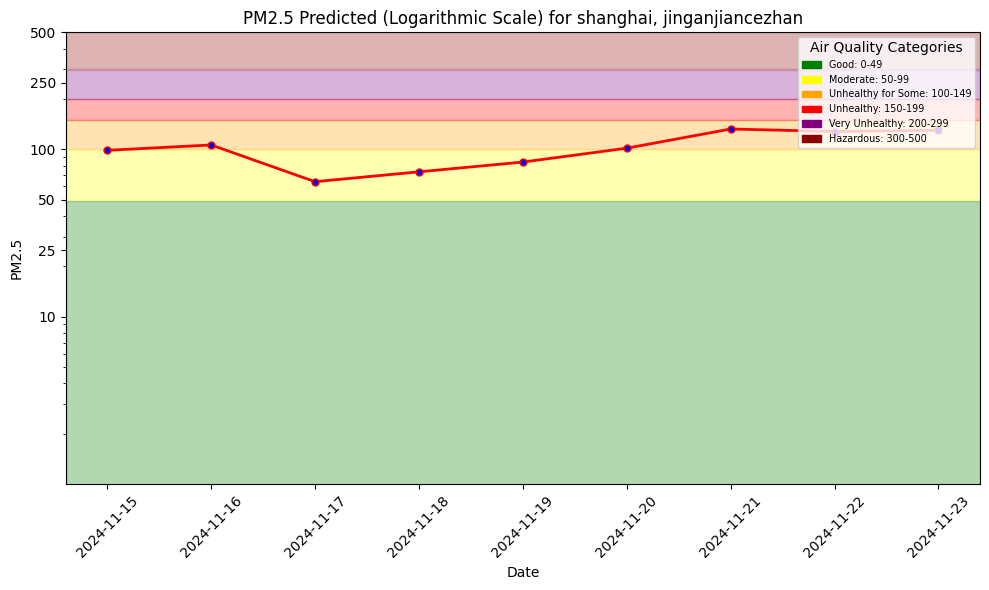

In [12]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [5]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=5,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_5_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163420/jobs/named/aq_predictions_5_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2aa66890910>, None)

In [6]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


In [7]:
display(monitor_fg.read().sort_values(by=['date'], ascending=True))
display(monitoring_df)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_18,pm25_19,pm25_20,pm25_21,predicted_pm25_1,predicted_pm25_2,predicted_pm25,street,country,days_before_forecast_day
9,2024-11-14 00:00:00+00:00,20.200001,0.2,7.421590,165.963730,shanghai,72.000000,93.000000,87.000000,61.000000,...,34.0,23.0,47.0,46.0,101.852516,107.827896,104.840210,jinganjiancezhan,china,1
3,2024-11-15 00:00:00+00:00,19.900000,0.0,7.993297,35.837746,shanghai,80.000000,72.000000,93.000000,87.000000,...,115.0,34.0,23.0,47.0,104.304710,92.962486,98.633598,jinganjiancezhan,china,1
17,2024-11-16 00:00:00+00:00,17.400000,0.0,10.661107,11.689341,shanghai,156.000000,80.000000,72.000000,93.000000,...,49.0,115.0,34.0,23.0,135.406403,115.618683,125.512543,jinganjiancezhan,china,1
2,2024-11-16 00:00:00+00:00,17.799999,0.0,10.182337,8.130019,shanghai,92.962486,80.000000,72.000000,93.000000,...,49.0,115.0,34.0,23.0,98.124367,114.236359,106.180359,jinganjiancezhan,china,2
15,2024-11-17 00:00:00+00:00,14.200000,0.0,16.171976,16.821489,shanghai,115.618683,156.000000,80.000000,72.000000,...,54.0,49.0,115.0,34.0,65.816467,81.779251,73.797859,jinganjiancezhan,china,2
22,2024-11-17 00:00:00+00:00,14.300000,0.0,15.941944,25.407679,shanghai,80.000000,156.000000,80.000000,72.000000,...,54.0,49.0,115.0,34.0,55.394817,81.732674,68.563744,jinganjiancezhan,china,1
1,2024-11-17 00:00:00+00:00,14.200000,0.0,16.279802,18.034380,shanghai,114.236359,92.962486,80.000000,72.000000,...,54.0,49.0,115.0,34.0,62.609203,65.173820,63.891510,jinganjiancezhan,china,3
6,2024-11-18 00:00:00+00:00,12.000000,0.0,13.779114,19.855309,shanghai,65.173820,114.236359,92.962486,80.000000,...,49.0,54.0,49.0,115.0,73.561996,73.220428,73.391212,jinganjiancezhan,china,4
23,2024-11-18 00:00:00+00:00,12.650000,0.0,15.408671,52.594578,shanghai,81.732674,80.000000,156.000000,80.000000,...,49.0,54.0,49.0,115.0,61.648785,69.414429,65.531609,jinganjiancezhan,china,2
14,2024-11-18 00:00:00+00:00,11.850000,0.0,12.303366,20.556128,shanghai,81.779251,115.618683,156.000000,80.000000,...,49.0,54.0,49.0,115.0,89.641647,83.769562,86.705605,jinganjiancezhan,china,3


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_18,pm25_19,pm25_20,pm25_21,predicted_pm25_1,predicted_pm25_2,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-15 00:00:00+00:00,19.900000,0.0,7.993297,35.837746,shanghai,80.0,72.0,93.0,87.0,...,115.0,34.0,23.0,47.0,104.304710,92.962486,98.633598,jinganjiancezhan,china,1
1,2024-11-14 00:00:00+00:00,20.200001,0.2,7.421590,165.963730,shanghai,72.0,93.0,87.0,61.0,...,34.0,23.0,47.0,46.0,101.852516,107.827896,104.840210,jinganjiancezhan,china,1
2,2024-11-16 00:00:00+00:00,17.400000,0.0,10.661107,11.689341,shanghai,156.0,80.0,72.0,93.0,...,49.0,115.0,34.0,23.0,135.406403,115.618683,125.512543,jinganjiancezhan,china,1
3,2024-11-17 00:00:00+00:00,14.300000,0.0,15.941944,25.407679,shanghai,80.0,156.0,80.0,72.0,...,54.0,49.0,115.0,34.0,55.394817,81.732674,68.563744,jinganjiancezhan,china,1
4,2024-11-18 00:00:00+00:00,12.600000,0.0,12.181624,34.159744,shanghai,13.0,80.0,156.0,80.0,...,49.0,54.0,49.0,115.0,60.106277,76.476326,68.291306,jinganjiancezhan,china,1
5,2024-11-19 00:00:00+00:00,12.300000,0.0,6.489992,340.559875,shanghai,34.0,13.0,80.0,156.0,...,20.0,49.0,54.0,49.0,63.858532,97.047012,80.452774,jinganjiancezhan,china,1


In [8]:
air_quality_df = air_quality_fg.read()
air_quality_fg.read().sort_values(by=['date'], ascending=True).tail(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.56s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,date,pm25,country,city,street,url
3955,2024-11-14 00:00:00+00:00,80.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3956,2024-11-15 00:00:00+00:00,156.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3957,2024-11-16 00:00:00+00:00,80.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3958,2024-11-17 00:00:00+00:00,13.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3959,2024-11-18 00:00:00+00:00,34.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486


In [9]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    # hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model1, retrieved_xgboost_model2)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-14 00:00:00+00:00,104.840210,80.0
0,2024-11-15 00:00:00+00:00,98.633598,156.0
2,2024-11-16 00:00:00+00:00,125.512543,80.0
3,2024-11-17 00:00:00+00:00,68.563744,13.0
4,2024-11-18 00:00:00+00:00,68.291306,34.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

2024-11-18 20:18:44,160 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



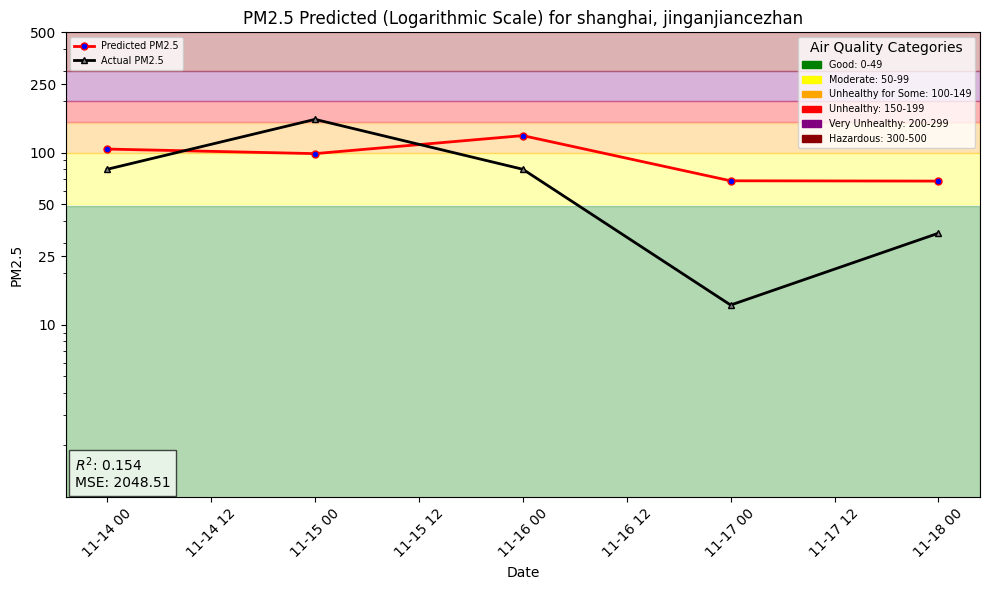

In [10]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()